# University of Exeter
## College of Engineering, Mathematics and Physical  Sciences
### ECM3420/ECMM445 - Learning From Data

#### Coursework 2 - Clutering

### Enter your candidate number here: 123446

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as dst
import matplotlib.cm as cm
from scipy import stats

In [8]:
iris_names = ["sepal-length", "sepal-width", "petal-length", "petal-width", "flower"]
iris = pd.read_csv("iris.txt",
                     sep=',',# In the file, attributes are separated by white spaces
                     names=iris_names)


wine_names = ["y","Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids", "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]
wine = pd.read_csv("wine.txt",
                     sep=',',# In the file, attributes are separated by white spaces
                     names=wine_names)

cluster_validation_names = ["x1", "x2"]
cluster_validation = pd.read_csv("cluster_validation_data.txt",
                     sep=',',# In the file, attributes are separated by white spaces
                     names=cluster_validation_names)

In [33]:
X_iris, y_iris = split(iris, iris.shape[1]-1)
X_wine, y_wine = split(wine, 0)

X_iris_std = standardise(X_iris)
X_wine_std = standardise(X_wine)
X_cluster_validation_std = standardise(cluster_validation)

In [5]:
def split(X, column_index):
    """
    Helper function to split the data into values and labels.
    
    Parameters:
        X: The dataframe to be split.
        column_index: The column with the labels
        
    Returns:
        X_values: The dataframe without the label column
        y: A label vector
    """
   
    X_values = X.drop(X.columns[[column_index]], axis=1)
   
    y = X.iloc[:, column_index]
    
    return X_values, y


In [9]:
def get_cluster(X, cluster_label):
    """
    Gets all data points belonging to a specific cluster.
    
    Parameters:
        X: A pandas dataframe with labels in the last column
        cluster_label: The label of the cluster for which rows are returned
        
    Returns:
        cluster: A pandas dataframe with rows in the specified cluster
    """
    
    cluster = X.loc[X.iloc[:,X.shape[1]-1] == cluster_label]
    return cluster

In [10]:
def get_centroid(cluster):
    return cluster.iloc[:, 0:cluster.shape[1]-1].mean(axis=0).values
    

In [11]:
def get_centroids(X):
    """
    Finds the centroids for all clusters in the dataset X.
    
    Parameters:
        X: The dataset. Labels must be in a column called y.
        
    Returns:
        centroids: A numpy array with all centroids.
    """
    k = np.unique(X.iloc[:, X.shape[1]-1])
    
    centroids = np.ones((k.size, X.shape[1]-1))
    for label in k:
        cluster = X.loc[X["y"] == label]
        centroid = get_centroid(cluster)
        centroids[label] = centroid
        
    return centroids

In [32]:
def standardise(X):
    """
    Standardises the given dataset X.
    
    Parameters:
        X: A 2D numpy array or Pandas dataframe without class labels.
        
    Returns:
        X_std: The standardised data as a Pandas Dataframe
    """
    X_std = stats.zscore(X)
    return pd.DataFrame(X_std)

## WP1

In [20]:
def kmeans(x,k,max_itr=100):
    """
    Performs kmeans clustering on dataset x.
    
    Parameters:
    x: the data do be clustered. The data should be unlabeled.
    k: the number of clusters
    max_itr: the maximum number of iterations
    
    Returns:
    cluster_labels: the cluster membership labels for each element in the data x as a pandas series
    """
    #add a column for class labels to the data
    x_class = x.assign(y = np.zeros(x.shape[0]))
  
    #create a partition with k parts. Each entry in the partition is the centroid of a cluster
    partition = x.sample(k).values
    
    for itr in range(max_itr):
        
        #matrix with all values except for class labels
        x_val = split(x_class, x_class.shape[1]-1)[0].values
        
        #matrix for samples' distances to cluster centroids
        dist_matrix = np.zeros((x.shape[0], k))
       
        #create a matrix where each row is the sample's distance to all k clusters. Each column corresponds to a cluster
        for cluster in range(k):
            
            #get the distance to centroid k for all samples in the data. Dist is a vector.
            dist = np.apply_along_axis(np.linalg.norm, 1, x_val-partition[cluster])
            
            #insert distance vector into matrix.
            dist_matrix[:, cluster] = dist
            
        #get a vector of indeces so that the new clusters can be assigned 
        min_dist_indeces = np.argmin(dist_matrix, axis=1)
        
        #assign the new cluster labels to the data
        x_class["y"] = min_dist_indeces
        
        new_partition = np.zeros((k, x.shape[1]))
        
        #recompute the centroids
        for cluster_index in range(k):
            #get each cluster
            cluster = get_cluster(x_class, cluster_index)
            
            #the new centroid is the average value for each dimension
            centroid = get_centroid(cluster)
            
            #assign the new centroids
            new_partition[cluster_index] = centroid
          
        cluster_labels = x_class.iloc[:,cluster.shape[1]-1]
        
        if np.array_equal(partition, new_partition):
            return cluster_labels
        
        partition = new_partition
    
    return cluster_labels

#### kmeans explanation
The data passed to the kmeans algorithm is unlabeled. First, k random samples are selected from the data each of which will be the centroid of a cluster. Then, a label column with all zeros is added to the data set x so that later on samples of the data can be associated with a cluster. For each iteration of the algorithm, the label column is removed so that euclidian distances can be calculated easier. The distances to each centroid are stored in a matrix where each column contains the distances of all data points to the centroid of a cluster. Each row in the matrix corresponds to a row in the dataset.

| Cluster 0 | Cluster 1 | Cluster 2 |
| --- | --- | --- |
| 3.45 | 2.10 | 0.84 |
| 4.12 | 1.87 | 5.32 |
| 0.98 | 3.08 | 1.45 |

It is then possible to get a vector containing the the indeces of the clusters with the closest distances. Again, each row correponds to a row in the dataset.

| Closest Clusters |
| --- |
| Cluster 2 |
| Cluster 1 |
| Cluster 0 |

This vector is then assigned to the label column of the dataset. Thereafter, the centroids are recomputed by getting the rows belonging to each cluster and averaging each column.

## WP2

In [21]:
def davies_bouldin(X):
    """
    Calculates the Davis Bouldin index for all clusters in the dataset X.
    
    Parameters:
        X: a clustered dataset with labels as the last column.
    
    """
    #get the cluster labels
    k = np.unique(X.iloc[:, X.shape[1]-1])
    
   
    DB = 0
    
    # for every pair of cluster
    for cluster_label_i in k:
        
        D_ij_array = np.array([])
        
        for cluster_label_j in k:
            if (cluster_label_i != cluster_label_j):
                
                #get all rows belonging to cluster i
                get_cluster(X, cluster_label_i)
                cluster_i = get_cluster(X, cluster_label_i)
                
                #remove the labels from the cluster
                cluster_i = split(cluster_i, cluster_i.shape[1]-1)[0] #cluster_i.iloc[:, 0:cluster_i.shape[1]-1]
                
                #calculate the centroid of the cluster
                centroid_i = cluster_i.mean(axis=0).values
                
                #get distance from every data point in the cluster to the centroid
                dist_i = np.apply_along_axis(np.linalg.norm, 1, cluster_i-centroid_i)
                
                #average the distances from all data points to the centroid
                d_i = np.mean(dist_i)
                
                
                #get all rows belonging to cluster j
                cluster_j = get_cluster(X, cluster_label_j)
                
                #remove the labels from the cluster
                cluster_j = split(cluster_j, cluster_j.shape[1]-1)[0]
                
                #calculate the centroid of cluster j
                centroid_j = cluster_j.mean(axis=0).values
                
                #get distances from all data points in the cluster to the centroid
                dist_j = np.apply_along_axis(np.linalg.norm, 1, cluster_j-centroid_j)
                
                #average distance of all data points to the centroid
                d_j = np.mean(dist_j)
                
                #distance between cluster centroids
                d_ij = np.linalg.norm(centroid_i - centroid_j)
                
                D_ij = (d_i + d_j) / d_ij
                
                #append D_ij to a list and then get the max
                D_ij_array = np.append(D_ij_array, D_ij)
        
        DB += np.max(D_ij_array)       
    return (1/k.size) * DB

## WP3

In [22]:
def silhouette_scores(x, cluster_labels):
    """
    Calculates the silhouette score for dataset X.
    
    Parameters:
        x: an unlabeled pandas dataframe
        cluster_labels: a vector of labels
    """
    
    #get the cluster labels
    k = np.unique(cluster_labels)
    
    #create labeled dataframe to be able to extract clusters
    X = x.assign(y = cluster_labels)
    
    scores = np.array([])
 
    for row in X.values:
    
        #find the cluster that this data point belongs to
        #first get the label of the row
        #second find all rows corresponding to the label
        #third remove the label column from the cluster
        cluster_label = row[X.shape[1]-1]
        cluster = X.loc[X["y"] == cluster_label]
        cluster = cluster.iloc[:,:cluster.shape[1]-1].values
        
      
        #get distance of the row to all other data points in the cluster 
        dist = np.apply_along_axis(np.linalg.norm, 1, cluster-row[:X.shape[1]-1])
        
        #average all distances. 
        a_i = np.sum(dist) / (dist.shape[0]-1)
        b_is = np.array([])
    
        
        #remove the label of the current cluster so that the current
        #data point is only compared to the remaining clusters
        other_clusters = k.tolist()
        other_clusters.remove(cluster_label)
        
        #calculate distances to all other clusters and get the closest average distance
        for cluster_label_j in other_clusters:

            #get other clusters
            #first get all rows belonging to that cluster
            #second remove the column with labels
            cluster_j = X.loc[X["y"] == cluster_label_j]
            cluster_j = cluster_j.iloc[:,:cluster_j.shape[1]-1].values
            
            #calculate distance of current data point to all points in cluster_j
            dist = np.apply_along_axis(np.linalg.norm, 1, cluster_j-row[:X.shape[1]-1])
            avg = np.mean(dist)
            b_is = np.append(b_is, avg)
            
            #reinsert the previously removed label
            np.append(k,cluster_label)
        
        b_i = b_is[np.argmin(b_is)]  
        s_i = (b_i - a_i) / np.maximum(a_i, b_i)
        
        scores = np.append(scores, s_i)
    
    return scores



## WP4

In [23]:
def model_selection(X, k, max_itr=100):
    """
    Parameters:
        X: An unlabeled dataframe.
        k: The max number of clusters that should be evaluated, starting from k=2
        max_itr: The maximum number of iterations for the kmeans algorithm
        
    Return:
        db_scores: A vector of length k with the Davies Bouldin scores for each value of k.
    """
    db_scores = np.array([])
    for cluster in range(2, k+1):
        
        cluster_pred = kmeans(X, cluster, max_itr)
        X_label = X.assign(y = cluster_pred)
        db_score = davies_bouldin(X_label)
        db_scores = np.append(db_scores, db_score)
        
    return db_scores


In [24]:
def plot_model_selection(X, k, n_exp):
    """
    Runs a number of model selections and plots the results.
    
    Parameters:
        X: The dataset to be used for model selection
        k: The maximum number of clusters
        n_exp: The number of times model selection is supposed to be run
    """
    #store results in a matrix where each row corresponds to an experiment
    results = np.zeros((n_exp, k-1))
    
    #run the experiments
    for exp in range(n_exp):
        results[exp] = model_selection(X, k)
    
    #plot the results
    x_values = range(2, k+1) 
    plt.figure(2)
    plt.xlabel("Number of clusters")
    plt.ylabel("Davies Bouldin score")
    for exp in range(n_exp):
        plt.plot(x_values, results[exp], label="Experiment " + str(exp + 1), marker="o")
        
    plt.legend()

### Iris Model Selection

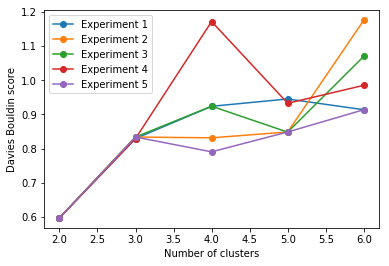

In [35]:
plot_model_selection(X_iris_std, 6, 5)

(1) The number of clusters with the lowest Davies Bouldin index is 2. The reason for this might be that 2 of the 3 classes in the iris data are spatially close such that within to between cluster ratio for the 2 leads to a higher Davies Bouldin score. 

(2) Although the ground truth is 3 classes, the DB suggests 2. 

### Wine Model Selection

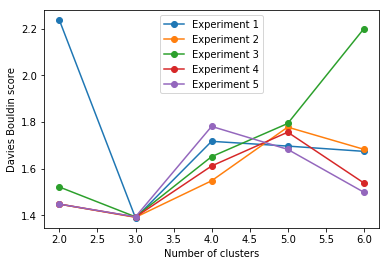

In [36]:
plot_model_selection(X_wine_std, 6, 5)

(1)It seems that partitioning the dataset into 3 clusters gives the best result. Although using 5 clusters also achieves good results one experiment respectively. 

(2) The recommend number of clusters by the Davies Bouldin score is the same as the ground truth, namely 3. 

### Cluster Validation Model Selection

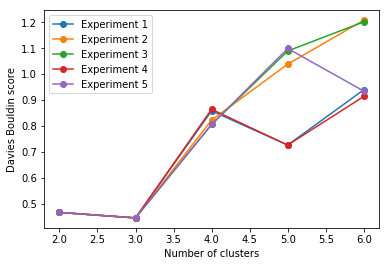

In [31]:
plot_model_selection(X_cluster_validation_std, 6, 5)

For the cluster validation set, the optimal number of partitions is 3.

## WP5

In [42]:
def plot_silhouette(X,max_k):
    range_n_clusters = range(2,max_k+1)
   
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        #clusterer
        
        ####  Use your kmeans function below, changing the code if necessary
        cluster_labels = kmeans(X,n_clusters).values
        
        ## Use your sihouette score function(s) below.
        sample_silhouette_values = silhouette_scores(X, cluster_labels)
        
        silhouette_avg = np.mean(sample_silhouette_values)
        

        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]
    
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X.values[:, 0], X.values[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        X_class = X.assign(y = cluster_labels)     
        
        centers = get_centroids(X_class) #clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

## WP6

The silhouette score indicates how well a data point belongs to a cluster. A silhouette score close to 1 means that the data point is closer to the centroid of its cluster whereas a score close to -1 means that the point is closer to the centroid of another cluster. Thus, the higher the silhouette score, the "more" cohesive it is with other data points in it cluster. A partition with many low scores indicates too few or too many clusters. A high average silhouette score where all partitions are just under or just above is an indicator of good quality clustering. The width of each partition of the silhouette plot indicates the number of data points in that cluster.

The silhouette scores are with few exceptions very dependent on how the kmeans algorithm initialises the centroids. This is especially true for larger values of k, as there may be multiple cluster hogging up a disproportionate number of data points.

For n_clusters = 2 The average silhouette_score is : 0.580184463257396
For n_clusters = 3 The average silhouette_score is : 0.46214947389312006
For n_clusters = 4 The average silhouette_score is : 0.39048202055389036
For n_clusters = 5 The average silhouette_score is : 0.3840424179180308
For n_clusters = 6 The average silhouette_score is : 0.35272787322836163


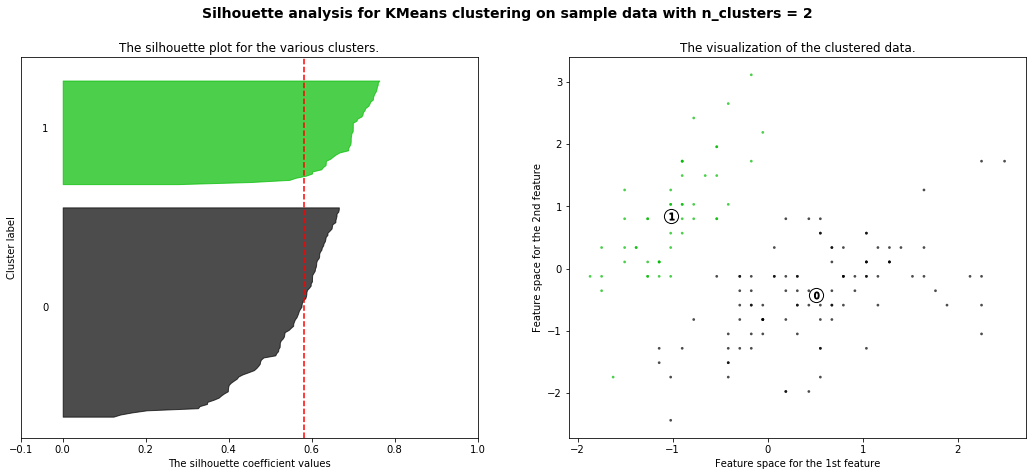

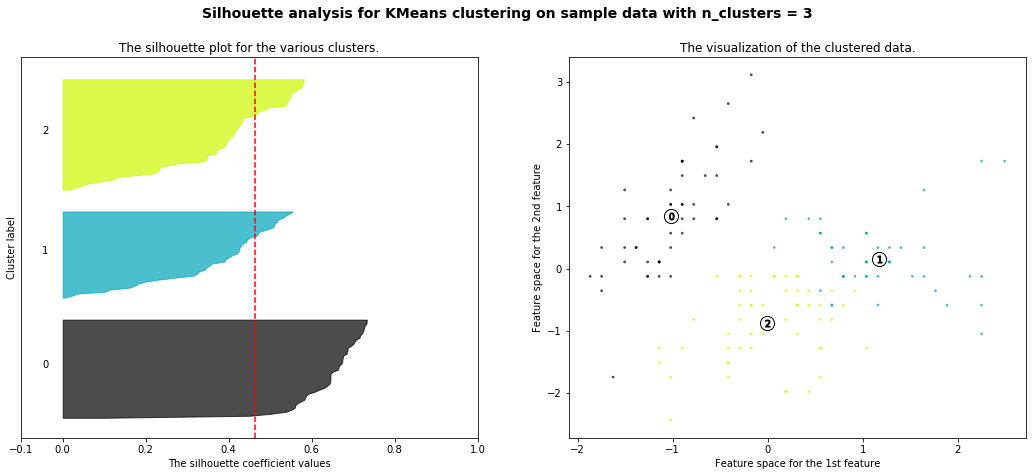

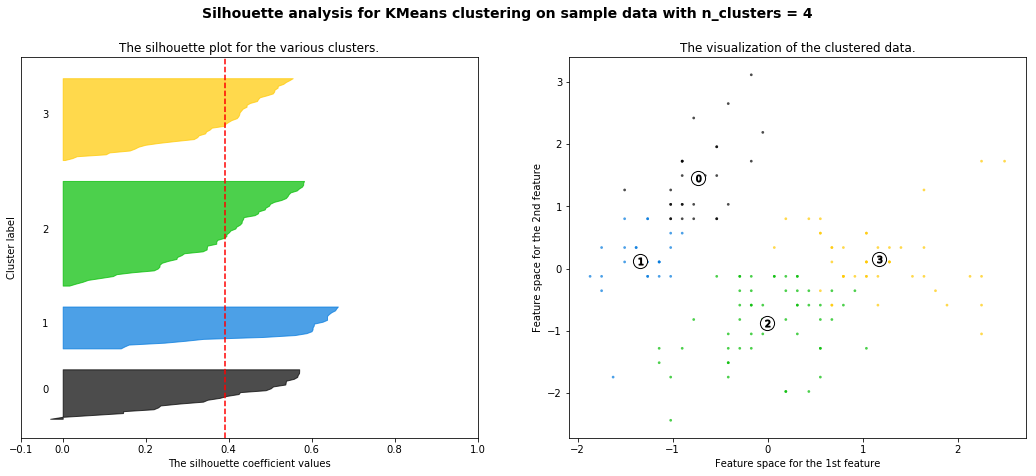

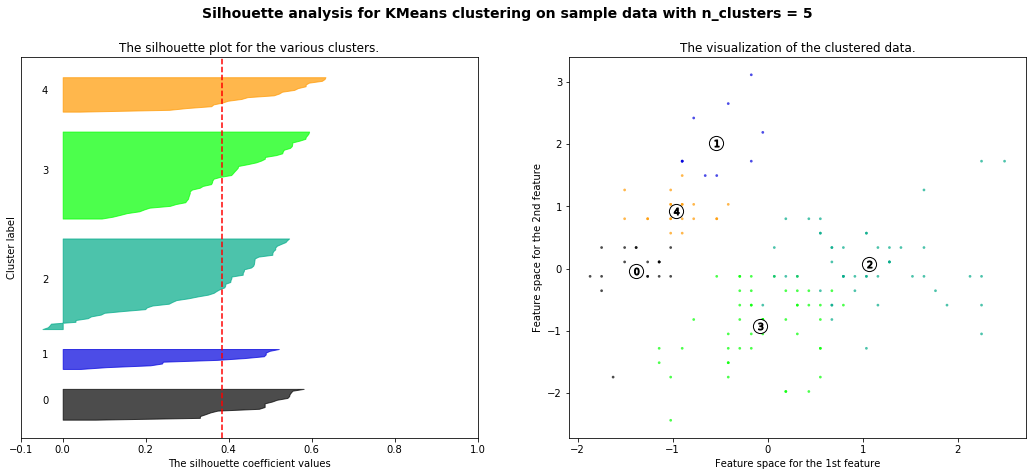

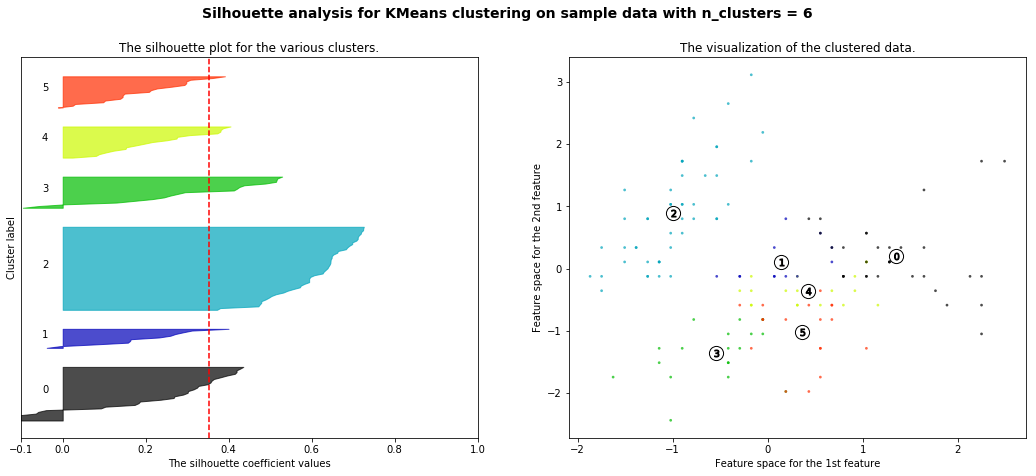

In [43]:
max_k = 6
plot_silhouette(X_iris_std, max_k)



k = 2
(1) For 2 clusters, cluster 0 has roughly twice the number of data points than cluster 1. From this we can conclude that the points in the dataset are distributed into two uneven groups as can be seen in the feature space. The average silhouette score is moderately high with 0.68, conveying the fact that overall most data points fit well within their assigned cluster. There are very few data points with low silhouette scores, which means that the average is not distorted by extremes either.

k = 3
(1) For 3 clusters, the number of data points is more evenly distributed when compared to k = 2. Although, the average silhouette score is lower than in the previous configuration. This is the case because data points in clusters 1 and 2 have much lower silhouette scores than the points in cluster 0. Cluster 1 even has points with negative values, indicating that they should belong to another cluster. Although the clustering is more distributed, data points in cluster 0 have high similarity while those in 1 and 2 not so much.

k = 4
(1) 4 clusters produces worse results than 3. The distribution of points across clusters starts to become more uneven again. Clusters 2 and 3 both have around double the number of data points when compared to clusters 0 and 1. Although clusters 0 and 1 have few data points with low silhouette scores. The average silhouette score is again lower because clusters 2 and 3 have more average and low score data points. Consequentially, the average silhouette score is also lower.

k = 5
(1) Using 5 clusters, the partitions are unequal in size and in their silhouette scores. The average silhouette score is the second lowest out of all values for k as clusters are close together. Individual data points therefore have lower silhouette values.

k = 6
(1) Using 6 clusters results in the lowest silhouette score, with uneven cluster sizes. Cluster 2 has about a quarter of all data points and has the most points with the highest scores. The centroids of the other clusters are all very close together, meaning that silhouette scores will be low as well. This is exactly what can be observed in clusters 0 and 3.

(2) The average silhouette score is the highest for k = 2, suggesting that 2 clusters is the best choice for this dataset.

(3) The clustering algorithm was unable to capture the ground truth of 3 classes. Using clustering metrics does not always capture the real number of classes because the real world does not always obey our rules. Data points in the real world might have similarities but still be in different classes.

For n_clusters = 2 The average silhouette_score is : 0.2683134097105212
For n_clusters = 3 The average silhouette_score is : 0.2848589191898987
For n_clusters = 4 The average silhouette_score is : 0.21649965091225074
For n_clusters = 5 The average silhouette_score is : 0.216032845086744
For n_clusters = 6 The average silhouette_score is : 0.18995628934536976


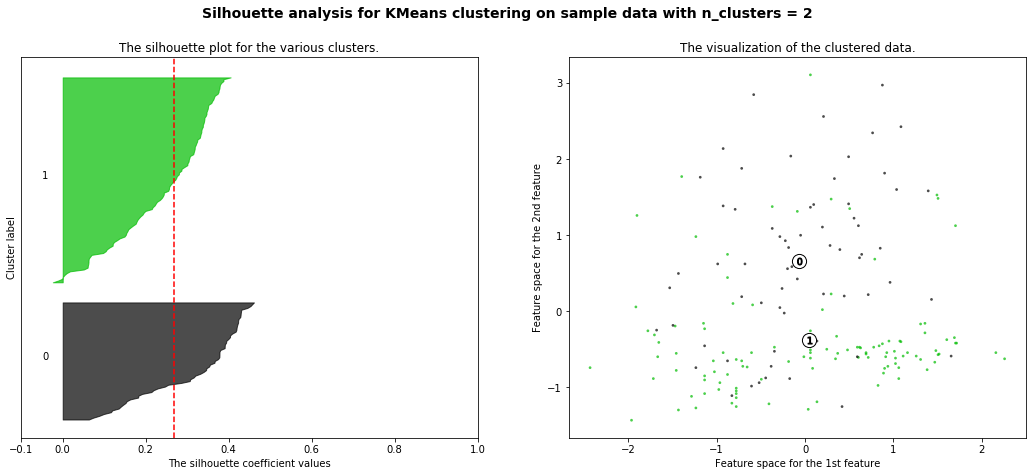

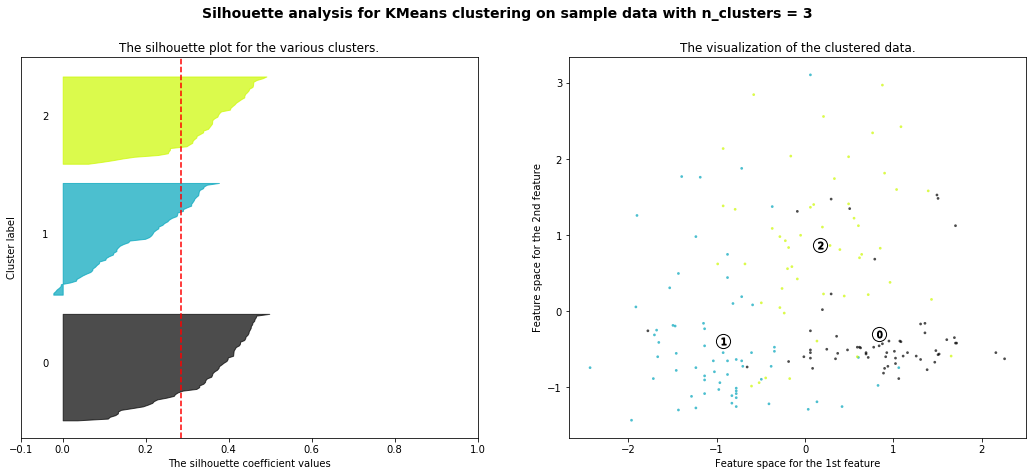

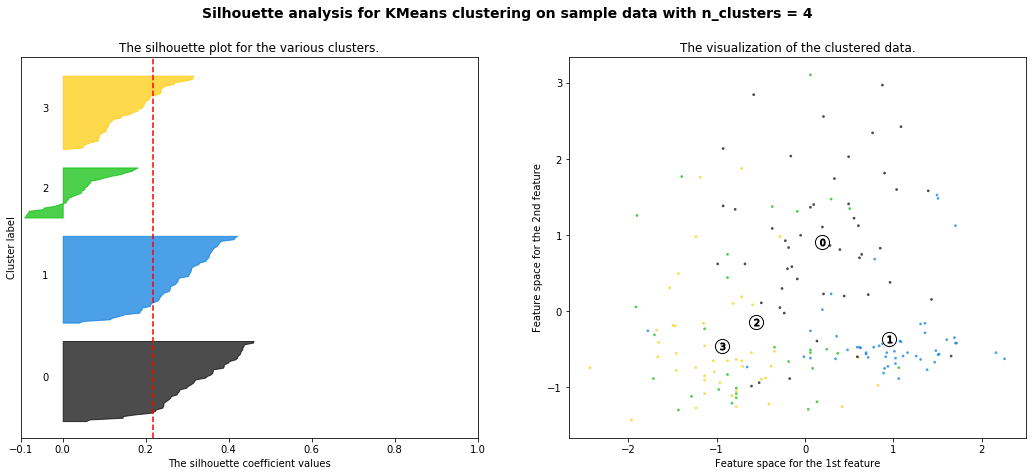

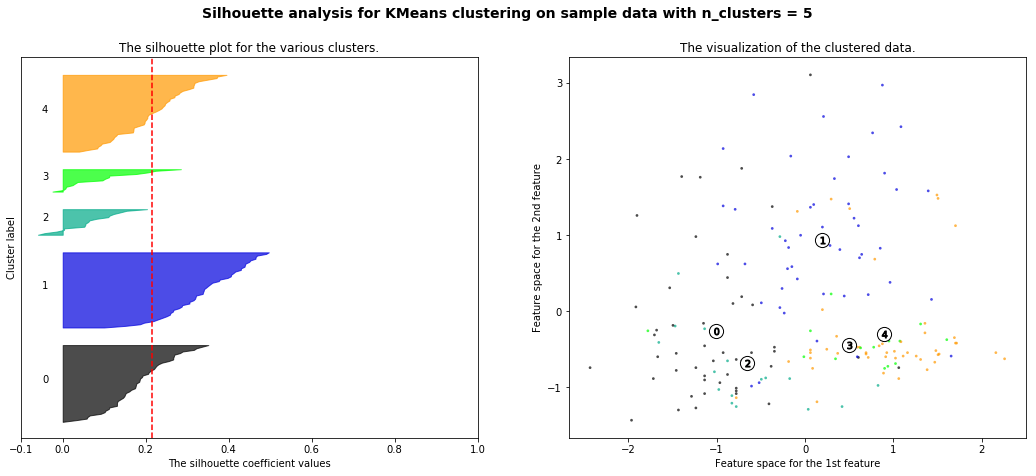

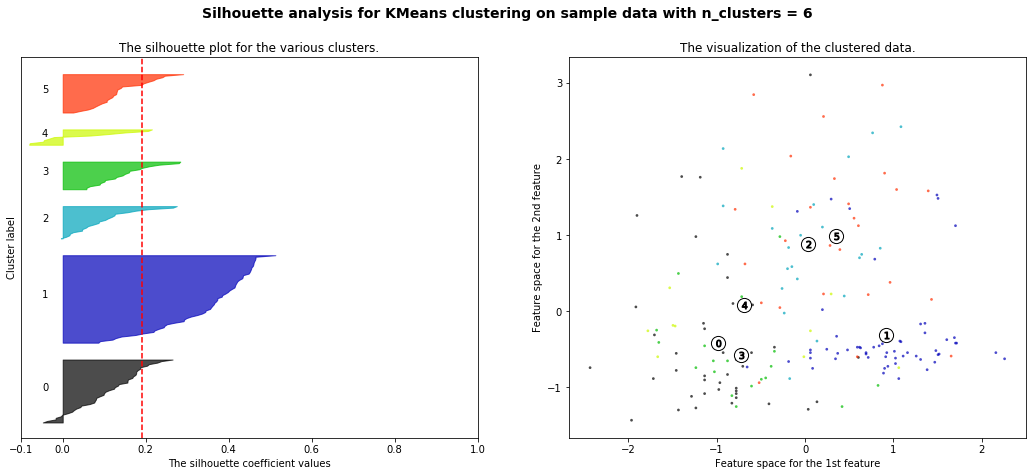

In [45]:
plot_silhouette(X_wine_std, max_k)

k = 2
(1) With 2 clusters, the partitions are unequal. Cluster 1 has double the number of data points than cluster 0. The average silhouette value is the second highest. Cluster 1 has more data points with lower silhouette scores and closer to average silhouette scores. There are no extreme silhouette values in either cluster however, meaning that the average accurately reflects the silhouette values.

k = 3
(1) Using 3 paritions, the number of points in each of them is fairly equal. The average silhouette score is the highest out of all values for k. Cluster 1 has a couple of negative scores as a result of their vincinity to other the two other clusters. Otherwise, the distribution of silhouette scores is roughly equal for all clusters.

k = 4
(1) The clusters are very unequal in size and in their distribution of silhouette values. Cluster 2 has very few good scores when compared to the other clusters. Clusters 0 and 1 are well separated from other clusters as they have relatively high scores and a similar shape.

k = 5
(1) 5 clusters has one of the lowest average silhouette value because the partitions are unequal in size and their distribution of silhouette scores. There are clusters with poor silhouette scores dragging down the average (2,3). This happens because there are too many clusters and data points are too close together. Overall, this is bad clustering.

k = 6
(1) The average silhouette score is the lowest of k = 6. There is a cluster with disproportionally many data points and very high silhouette values, meaning that the clustering is very unequal. Other clusters have few data points and low silhouette score. This is also bad clustering.

(2,3) The recommend number of clusters for the data is 3, which coincides with the number of actual classes (also 3).  

For n_clusters = 2 The average silhouette_score is : 0.6439937852306329
For n_clusters = 3 The average silhouette_score is : 0.6738163984313349
For n_clusters = 4 The average silhouette_score is : 0.5384240794496074
For n_clusters = 5 The average silhouette_score is : 0.5533018376875479
For n_clusters = 6 The average silhouette_score is : 0.4534756689543124


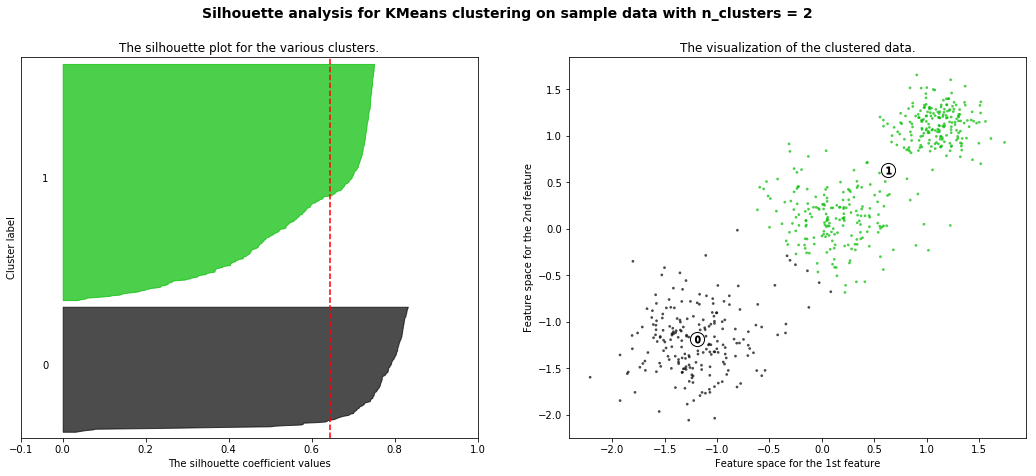

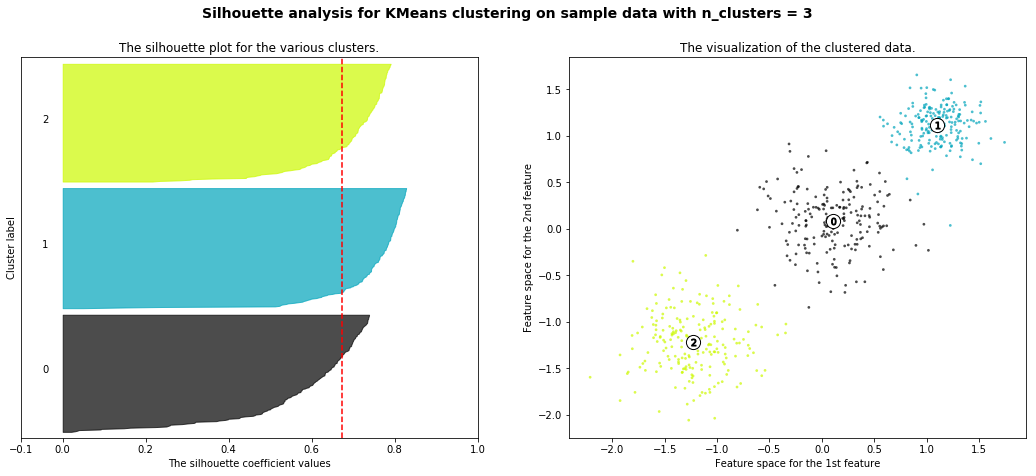

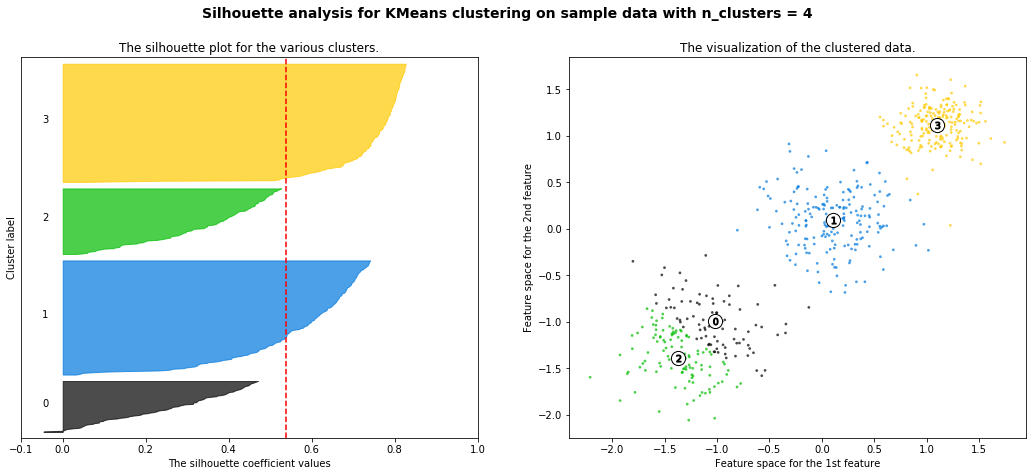

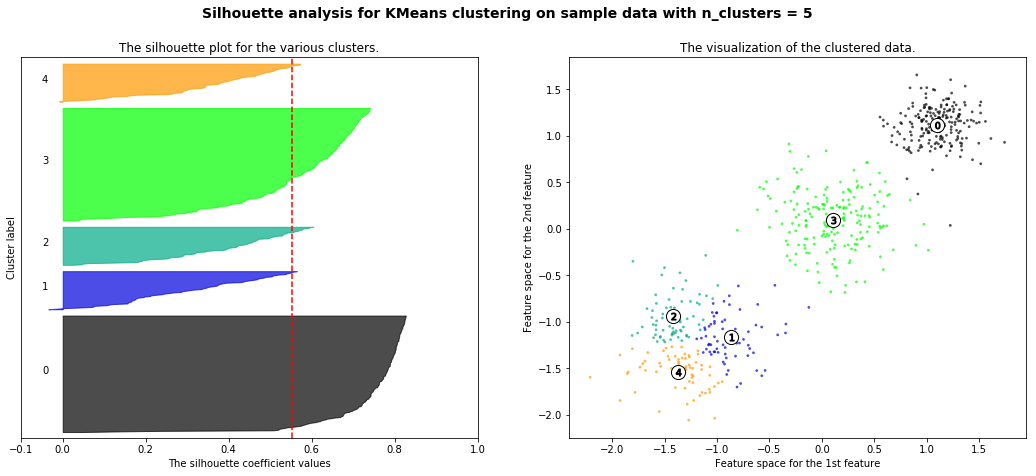

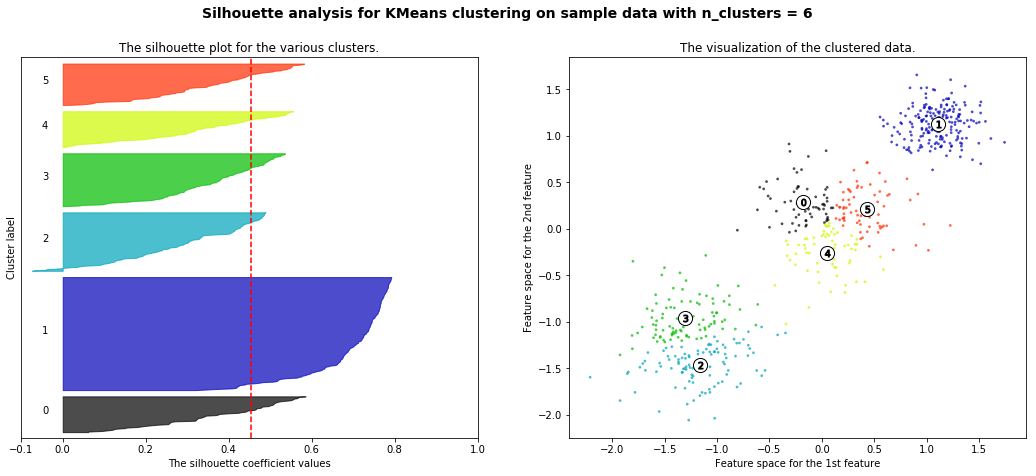

In [46]:
plot_silhouette(X_cluster_validation_std, max_k)

k = 2
(1) With 2 clusters, the partition is very unequal. Cluster 0 only has about half as many samples as cluster 1 (1/3 vs 2/3). The silhouette for cluster 1 has many more samples with low silhouette scores as can bee seen by the more gradual curve in the silhouette as well as the feature space to the right. 

k = 3
(1) 3 clusters achieves an even partitioning as well as high silhouette score. The silhouettes are of almost of equal width and height, indicating that the natural underlying structure of the data is in 3 separate clusters. This creates a high average silhouette score as well as very few data points with low silhouette values.

k = 4
(1) This creates an uneven partitioning of the feature space. 2 of the clusters are similar in size and silhouette values with clusters 0 and 2 being small with lower and even negative silhouette scores. This shows that the cluster has many data points which would be better placed in other partitions.

k = 5
(1) This silhouette plot shows very uneven clusters. There are two clusters with many more data points and higher silhouette scores when compared to the rest which are small with many low and/or negative values. It shows that there are two clusters where data points are very similar to each other and far away from any other clusters. The clusters 1, 2, 4 on the other hand are all very close together, resulting in low silhouette scores and lowering the average silhouette score.

k = 6
(1) Again, the partitioning is very unequal. A single cluster has disproportionally many data points and therefore high scores. The average score is the lowest because there are many clusters that are close together. Hence, data points within these clusters have low silhouette scores. 

(2) The optimal number of clusters for this dataset is 3 because it creates the highest silhouette score. Looking at the feature space also makes it easy to see why that is the case. There are 3 distinct areas where data is concentrated.